In [60]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg
import scipy.ndimage
import scipy.optimize
import scipy.special
import sklearn.datasets

from chmp.ds import mpl_set, get_color_cycle
from chmp.experiment import Loop

In [2]:
# helper for gradient checking
def approximate_gradient(x, func, eps=1e-5):
    res = np.zeros(x.size)
    
    for i in range(x.size):
        d = np.zeros(x.size)
        d[i] = eps
        
        res[i] = (func(x + d) - func(x - d)) / (2 * eps)
    
    return res

# Linear Models for classification

## Discriminant Functions

### Fischer's Linear Discriminant

In [3]:
n_samples = 200 

y = np.random.binomial(1, p=0.5, size=n_samples)
mu = np.asarray([[-1, 0.5], [1, 0]])
sigma = np.asarray([
    [[+0.65, +0.35],
     [+0.35, +0.65]],
    [[+0.75, +0.35],
     [+0.35, +0.75]],
])

x = mu[y] + np.einsum('ij...,ij...->i...', sigma[y], np.random.normal(size=(n_samples, 2)))

simple_w = np.mean(x[y == 0], axis=0) - np.mean(x[y == 1], axis=0)
simple_w = simple_w / (simple_w @ simple_w) ** 0.5

delta_0 = x[y == 0] - np.mean(x[y == 0], axis=0, keepdims=True)
delta_1 = x[y == 1] - np.mean(x[y == 1], axis=0, keepdims=True)
S_w = delta_0.T @ delta_0 + delta_1.T @ delta_1

fischer_w = np.linalg.pinv(S_w) @ simple_w
fischer_w = fischer_w / (fischer_w @ fischer_w) ** 0.5

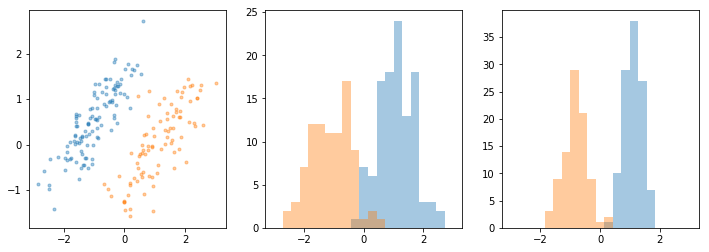

In [4]:
c0, c1 = get_color_cycle(2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(x[y == 0, 0], x[y == 0, 1], color=c0, alpha=0.4, marker='.')
plt.scatter(x[y == 1, 0], x[y == 1, 1], color=c1, alpha=0.4, marker='.')

plt.subplot(1, 3, 2)
plt.hist(x[y == 0] @ simple_w, alpha=0.4, range=(-3, +3), bins=21, color=c0)
plt.hist(x[y == 1] @ simple_w, alpha=0.4, range=(-3, +3), bins=21, color=c1)

plt.subplot(1, 3, 3)
plt.hist(x[y == 0] @ fischer_w, alpha=0.4, range=(-3, +3), bins=21, color=c0)
plt.hist(x[y == 1] @ fischer_w, alpha=0.4, range=(-3, +3), bins=21, color=c1)
pass

### Perceptron Algorithm

In [5]:
n_samples = 200 

y = np.random.binomial(1, p=0.5, size=n_samples)
mu = np.asarray([[-1, 0.5], [1, 0]])
sigma = np.asarray([
    [[+0.65, +0.35],
     [+0.35, +0.65]],
    [[+0.75, +0.35],
     [+0.35, +0.75]],
])

x = mu[y] + np.einsum('ij...,ij...->i...', sigma[y], np.random.normal(size=(n_samples, 2)))
x = np.concatenate([np.ones(n_samples)[:, None], x], axis=1)

y = 2 * y - 1

In [6]:
w = np.random.normal(loc=1e-2, size=3)
errors = []

for loop, _ in Loop.over(range(10)):
    idx = np.arange(n_samples)
    np.random.shuffle(idx)
    for i in idx:
        if y[i] * np.sign(x[i, :] @ w):
            w += y[i] * x[i, :]
    
        errors += [np.mean(y * np.sign(x @ w) + 1) / 2]
    print(f'{loop}'.ljust(20), end='\r')

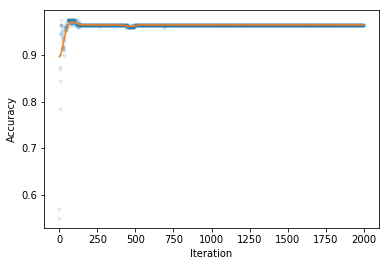

In [7]:
plt.plot(errors, '.', alpha=0.1)
plt.plot(scipy.ndimage.gaussian_filter(errors, 20), '-')
mpl_set(ylabel='Accuracy', xlabel='Iteration')

## Probabilistic Generative Models

Assume probability of data given class $p(x|C_k)$. This results in the posterior:

$$
\begin{align}
    p(C_k|x) 
        &= \frac{p(x|C_k) p(C_k)}{\sum_k p(x|C_k) p(C_k)} \\
        &= \frac{e^{a_k(x)}}{\sum_k e^{a_k(x)}}
\end{align}
$$

with $a_k(x) = \log p(x|C_k)  + \log p(C_k)$. For two classes this can be written as:

$$
\begin{align}
    p(C_1|x) &= \sigma(a(x)) \\
    a(x) &= c_1(x) - c_0(x)
\end{align}
$$

For example for continuous features $p(x|C_k)$ could be modeled as a Gaussian:

$$
    a(x) = 
        -\frac{1}{2} (x - \mu_1)^T \Sigma_1 (x - \mu_1) + 
        \frac{1}{2} (x - \mu_2)^T \Sigma_2 (x - \mu_2) +
        \frac{1}{2} \log \frac{|\Sigma_1|}{|\Sigma_2|} +
        \log \frac{p(C_1)}{p(C_0)}
$$

To fit, parametrize $p(C_1) = \pi, p(C_0) = 1 - \pi$ and optimize the joint loglikelihood $p(x|C_k)p(C_k)$. Then use Bayes theorem to obtain class probabilities.

To reduce the number of parameters for discrete features use Naive Bayes approximation:

$$
\begin{align}
    p(\{x\}|C_k) 
        &= \sum_i p(x_i|C_k) &\; \\
        &= \sum_i \mu_{ik}^{x_i} (1 - \mu_{ik})^{1 - x_i} &&\text{for binary $x_i$}
\end{align}
$$

This results in

$$
\begin{align}
    a(\{ x \}) &= 
        \sum_i x_i \log \frac{\mu_{i1} (1 - \mu_{i0})}{\mu_{i0} (1 - \mu_{i1})} +
        \sum_i \log \frac{1 - \mu_{i0}}{1 - \mu_{i1}} +
        \log \frac{p(C_1)}{p(C_0)}
\end{align}
$$

## Probabilistic Discriminative Models

Instead of modelling the data and using Bayes theorem. Approximate the class probabilities directly by using the functional form. 

### Logistic Regression

Take $y \in \{-1, +1\}$. Then, the negative loglikelihood is given by:

$$
\begin{align}
    NLL 
        &= -\sum_n \log \sigma(y_n x_n^T w) + \frac{1}{2} \lambda w^T w 
\\
    \frac{\partial}{\partial w_\alpha} NLL 
        &= -\sum_n \sigma(-y_n x_n^T w) y_n x_{n\alpha} + \lambda w_\alpha
\\
    \frac{\partial^2}{\partial w_\alpha \partial w_\beta} NLL 
        &= \sum_n \sigma(y_n x_n^T w) \sigma(-y_n x_n^T w) x_{n\alpha} x_{n\beta} + \lambda
\end{align}
$$

In [34]:
def fit_logistic_regression(x, y, reg=0.0):
    N, M = x.shape
    y = 2 * y - 1
    
    w0 = np.random.uniform(low=-1e-2, high=+1e-2, size=M)
    
    def loss(w):
        return -np.mean(np.log(sigmoid(y * (x @ w)))) + (0.5 * reg / N) * (w @ w)
    
    def grad(w):
        return (
            -np.mean(sigmoid(-y * (x @ w))[:, None] * y[:, None] * x, axis=0) +
            reg / N * w
        )
    
    res = scipy.optimize.minimize(loss, w0, jac=grad, method='BFGS')
    if not res.success:
        raise ValueError(f'could not fit: {res.message}')
    
    return res.x


def sigmoid(x):
        p = x > 0
        s = 1.0 / (1.0 + np.exp(-np.abs(x)))
        return p * s + (1 - p) * (1 - s)

In [83]:
# do not shuffle to see posterior structure more clearly
x, y = sklearn.datasets.make_classification(random_state=42, shuffle=False)
w_logit = fit_logistic_regression(x, y)
w_logit_reg = fit_logistic_regression(x, y, reg=1e-3)

print('likelihood (no reg)', np.prod(sigmoid((2 * y - 1) * (x @ w_logit))))
print('likelihood (w/ reg)', np.prod(sigmoid((2 * y - 1) * (x @ w_logit_reg))))

likelihood (no reg) 0.999652286703
likelihood (w/ reg) 0.979098237265


### Probit regression

Assume noisy threshold model

$$
\begin{align}
    p(t = 1 | x) 
        &= \mathbb{E}_\theta \left[ w^T x > \theta \right] \\
        &= \int_{-\infty}^{+\infty}\mathrm{d}\theta\; p(\theta) \mathbb{1}\left[ w^T x > \theta \right] \\
        &= \int_{-\infty}^{+w^T x}\mathrm{d}\theta\; p(\theta)
\end{align}
$$

This model is called probit regression for $\theta \sim \mathcal{N}(0, 1)$.

In [10]:
def fit_probit_regression(x, y):
    N, M = x.shape
    y = 2 * y - 1
    
    w0 = np.random.uniform(low=-1e-2, high=+1e-2, size=M)
    
    def loss(w):
        return -np.mean(np.log(probit(y * (x @ w))))
    
    def grad(w):
        arg = y * (x @ w)
        scalar = probit_grad(arg) / probit(arg) * y
        return -np.mean(scalar[:, None] * x, axis=0)
    
    res = scipy.optimize.minimize(loss, w0, jac=grad, method='BFGS')
    if not res.success:
        raise ValueError(f'could not fit: {res.message}')
    
    return res.x


def probit(u):
    # NOTE the definition of the error function between Bishop and scipy differ
    return 0.5 * (1 + scipy.special.erf(u / np.sqrt(2)))


def probit_grad(u):
    return np.exp(-u ** 2.0 / 2) / (np.sqrt(2 * np.pi))

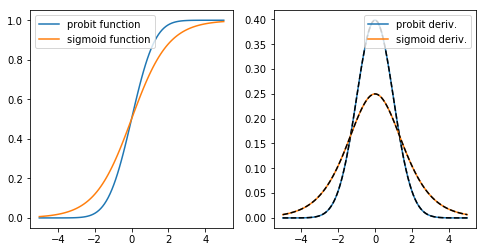

In [11]:
u = np.linspace(-5, +5, 100)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(u, probit(u), label='probit function')
plt.plot(u, sigmoid(u), label='sigmoid function')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(u, np.asarray([approximate_gradient(np.asarray([x]), probit) for x in u]), label='probit deriv.')
plt.plot(u, probit_grad(u), ls='--', c='k')

plt.plot(u, np.asarray([approximate_gradient(np.asarray([x]), sigmoid) for x in u]), label='sigmoid deriv.')
plt.plot(u, sigmoid(u) * (1 - sigmoid(u)), ls='--', c='k')

plt.legend(loc='best')
pass

In [12]:
w_probit = fit_probit_regression(x, y)
print('probit likelihood', np.prod(probit((2 * y - 1) * (x @ w_probit))))

probit likelihood 0.999933414634


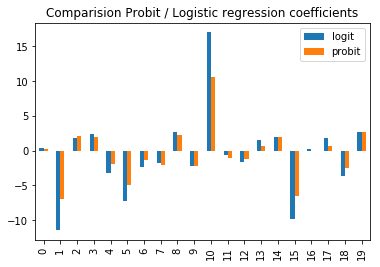

In [13]:
pd.DataFrame({'probit': w_probit, 'logit': w_logit}).plot.bar()
plt.title('Comparision Probit / Logistic regression coefficients')
pass

## Laplace Approximation

Talyor expand the log probability $p(z)$ around its maximum $\partial_{z} \log p(z) \big|_{z_0} = 0$. 
This results in:

$$
\begin{align}
    \log p(z) 
    &\approx 
        \log p(z_0) + 
        \frac{1}{2} (z - z_0)_\alpha (z - z_0)_\beta \; 
        \left[ \frac{\partial^2}{\partial z_\alpha \partial z_\beta} \log p(z) \right]_{z=z_0}
\\
    &= 
        \log p(z_0) - \frac{1}{2} (z - z_0)^T A (z - z_0)
\\
    &\approx 
        \mathcal{N}(z|z_0, A^{-1})
\\
    A_{\alpha\beta} &= -\left[ \frac{\partial^2}{\partial z_\alpha \partial z_\beta} \log p(z) \right]_{z=z_0}
\end{align}
$$

Note: As a result of the central limit theorem, the posterior distribution for a model is expected to become increasingly better approximated by a Gaussian as the number of observed data points is increased, and so we would expect the Laplace approximation to be most useful in situations where the number of data points is relatively large. (p. 216).

The same approach can be used to estimate the normalization constant of the data likelihood:

$$
\begin{align}
    \log p(\mathcal{D}) 
    &= 
        \log p(\mathcal{D}|\theta) + \log p(\theta) - 
        \log \int \mathrm{d}\theta\;  p(\mathcal{D}|\theta) p(\theta)
\\
    &\approx
        \log p(\mathcal{D}|\theta_\mathrm{MAP}) + \log p(\theta_\mathrm{MAP}) + 
        \frac{M}{2} \log 2\pi - \frac{1}{2} \log |A|
\\
    A_{\alpha\beta} &= 
        -\left[ 
            \frac{\partial^2}{\partial \theta_\alpha \partial \theta_\beta} 
                \log p(\mathcal{D}|\theta) p(\theta)
        \right]_{\theta = \theta_\mathrm{MAP}}
\end{align}
$$

## Bayesian Logistic Regression

$$
\begin{align}
    p(w) &= \mathcal{N}(w|0, \sigma_0^2)
\\
    p(y|w, x) &= \sigma(y w^T x)
\\
    \log p(w|\left\{y, x \right\}) 
    &= 
        \sum_n \log \sigma (y_n w^T x_n) -
        \frac{1}{2} \sigma_0^{-2} w^T w +
        \mathrm{const}
\\
    &\approx 
        \mathcal{N}(w|w_\mathrm{map}, A^{-1})
\end{align}
$$

Identify $\sigma_0^{-2} = \lambda$

In [88]:
N, M = x.shape

In [84]:
prior_var = 100
w_map = fit_logistic_regression(x, y, reg=1.0 / prior_var)

In [85]:
arg = (2 * y - 1) * (x @ w_map)
hessian = 1 / prior_var + np.sum(
    (sigmoid(arg) * sigmoid(-arg))[:, None, None] * x[:, None, :] * x[:, :, None],
    axis=0
)

In [92]:
posterior_var = np.linalg.pinv(hessian)

# NOTE: imaginary values can appear to due to numerical inaccuracies
posterior_std = np.real(scipy.linalg.sqrtm(posterior_var))

# draw 10 posterior samples
posterior_sample = w_map[None, :] + np.random.normal(size=[10, M]) @ posterior_std

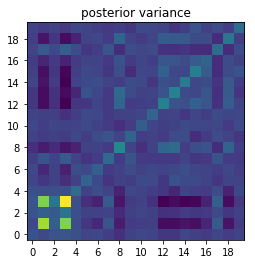

In [87]:
plt.imshow(posterior_var, origin='lower')
plt.xticks(range(0, 20, 2))
plt.yticks(range(0, 20, 2))
plt.title('posterior variance')
pass